In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional, List, Union


df = pd.read_excel("zbior_punktow.xlsx", 'Arkusz2')
dct = dict()
pkt_nazwa = list(df['U'])
pkt_x = list(df['x'])
pkt_y = list(df['y'])
for i in range(len(pkt_x)):
    dct[pkt_nazwa[i]] = (pkt_x[i], pkt_y[i])

df2 = pd.read_excel("zbior_punktow.xlsx", 'Arkusz3')

A0_idx = df2.A0.to_list()
A1_idx = df2.A1.to_list()
A2_idx = df2.A2.to_list()
A3_idx = df2.A3.to_list()

A0 = []
A1 = []
A2 = []
A3 = []

for i in range(len(A0_idx)):
    A0.append(dct[A0_idx[i]])
    A1.append(dct[A1_idx[i]])
    A2.append(dct[A2_idx[i]])
    A3.append(dct[A3_idx[i]])

B0 = []

A1xmin = min([point[0] for point in A1])
A2xmax = max([point[0] for point in A2])

for point_name in dct.keys():
    if A1xmin < dct[point_name][0] < A2xmax:
        if (dct[point_name] not in A1) and (dct[point_name] not in A2) and (dct[point_name] not in A0) and (dct[point_name] not in A3):
            B0.append(dct[point_name])

In [79]:
def plot_points(zbior: Optional[Union[Dict, List]], dct: Dict):
    # plt.figure(figsize=(20, 15))

    if isinstance(zbior, Dict):
        fig, ax = plt.subplots()
        fig.set_size_inches((20, 15))
        ax.set_ylim((0, 40))
        ax.set_xlim((0, 50))

        ax.scatter([zbior[point][0] for point in zbior.keys()], [zbior[point][1] for point in zbior.keys()])

        for key, coords in zbior.items():
            ax.annotate(key, coords)

    if isinstance(zbior, List):
        fig, ax = plt.subplots()
        fig.set_size_inches((20, 15))
        ax.set_ylim((0, 40))
        ax.set_xlim((0, 50))

        ax.scatter([point[0] for point in zbior], [point[1] for point in zbior])

        # dct = list(zbior.keys())[list(zbior.values()).index((point[0], point[1]))]
        

        for coords in zbior:
            key = list(dct.keys())[list(dct.values()).index((coords[0], coords[1]))]
            ax.annotate(key, coords)


In [80]:
def oblicz_d(A1_point,A2_point):
    x_A1, y_A1 = A1_point
    x_A2, y_A2 = A2_point
    d1 = (x_A2 - x_A1)/2
    d2 = (y_A2 - y_A1)/2
    # print(d1,d2)
    # if d1 > d2:
    #     d1, d2 = d2, d1
    return min(d1,d2)

def stworz_krzywa(A1_point,A2_point):
    d = oblicz_d(A1_point,A2_point)
    x_A1, y_A1 = A1_point
    x_A2, y_A2 = A2_point
    f1 = (x_A1+d,y_A1+d) 
    f2 = (x_A2-d,y_A2-d)
    return (A1_point,f1,f2,A2_point)

def oblicz_odleglosc(u,A1_point,A2_point):
    A1_point, f1, f2, A2_point = stworz_krzywa(A1_point,A2_point)
    # print(A1_point, f1, f2, A2_point)
    lista = [A1_point, f1, f2, A2_point]
    x_u, y_u = u
    odle = []
    for i in range(3):
        if lista[i][0]-lista[i+1][0] == 0:
            A = 0
            B = -1
            C = 0
        else: 
            B = -1
            A = (lista[i][1]-lista[i+1][1])/(lista[i][0]-lista[i+1][0])
            C = lista[i][1] - lista[i][0]*(lista[i][1]-lista[i+1][1])/(lista[i][0]-lista[i+1][0])
        odle.append((abs(A*x_u + B*y_u + C))/(A**2+B**2)**(1/2))
    return min(odle), odle.index(min(odle)), f1, f2

# print(oblicz_d(dct["N22"],dct['N12']))
# print(oblicz_odleglosc(dct['N22'],dct['N12'],dct['N5']))

def odleglosc(point_1,point_2):
    x_1, y_1 = point_1
    x_2, y_2 = point_2
    return ((x_2-x_1)**2 + (y_2 - y_1)**2)**(1/2)

def oblicz_wspolczynnik_skoringowy(u,A1_point,A2_point):
    # odle, idx, f1, f2 = oblicz_odleglosc(u,A1_point,A2_point)
    # odleglosci = [odleglosc(A1_point,f1),odleglosc(f1,f2),odleglosc(f2,A2_point)]
    # suma = odleglosci[0] + odleglosci[1] + odleglosci[2]
    y_max = A2_point[1]
    y_min = A1_point[0]
    return (u[1]-y_min)/(y_max-y_min)
    # suma_1 = suma/suma
    # # suma = 1
    # waga = odleglosci[idx]/suma
    # wsp_skoringowy = odle * waga
    # return wsp_skoringowy

ranking = []

for point in B0:
    suma = 0
    for A1_point in A1:
        for A2_point in A2:
            suma += oblicz_wspolczynnik_skoringowy(point,A1_point,A2_point)
            print("wspol", oblicz_wspolczynnik_skoringowy(point,A1_point,A2_point))
    point = list(dct.keys())[list(dct.values()).index((point[0], point[1]))]
    ranking.append((point,suma))

ranking = sorted(ranking, key = lambda tup: tup[1], reverse=False)
# print(oblicz_wspolczynnik_skoringowy())
# print(ranking)

wspol 0.7241379310344828
wspol 0.7777777777777778
wspol 1.0
wspol 1.3125
wspol 0.7142857142857143
wspol 0.7692307692307693
wspol 1.0
wspol 1.3333333333333333
wspol 0.68
wspol 0.7391304347826086
wspol 1.0
wspol 1.4166666666666667
wspol 0.6
wspol 0.6666666666666666
wspol 1.0
wspol 1.7142857142857142
wspol 0.27586206896551724
wspol 0.2962962962962963
wspol 0.38095238095238093
wspol 0.5
wspol 0.25
wspol 0.2692307692307692
wspol 0.35
wspol 0.4666666666666667
wspol 0.16
wspol 0.17391304347826086
wspol 0.23529411764705882
wspol 0.3333333333333333
wspol -0.05
wspol -0.05555555555555555
wspol -0.08333333333333333
wspol -0.14285714285714285
wspol 0.1724137931034483
wspol 0.18518518518518517
wspol 0.23809523809523808
wspol 0.3125
wspol 0.14285714285714285
wspol 0.15384615384615385
wspol 0.2
wspol 0.26666666666666666
wspol 0.04
wspol 0.043478260869565216
wspol 0.058823529411764705
wspol 0.08333333333333333
wspol -0.2
wspol -0.2222222222222222
wspol -0.3333333333333333
wspol -0.5714285714285714
wsp

AttributeError: 'list' object has no attribute 'items'

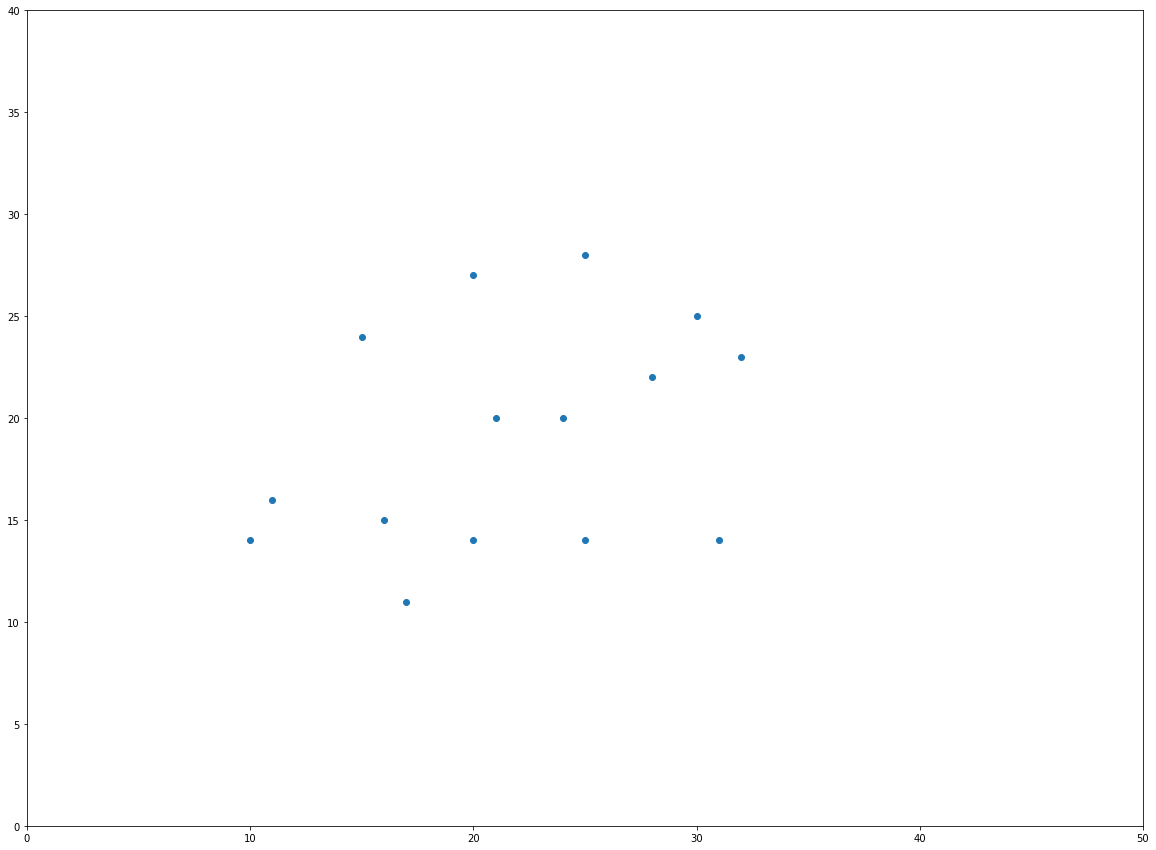

In [81]:
plot_points(B0, dct)